In [1]:
# from sklearn.cluster import KMeans
from sklearn.svm import SVC

import torch
import numpy as np

# import matplotlib.pyplot as plt

from functions import *
from SVMClass import *
from Kmeans import *

X: torch.Size([400, 2]) Y: torch.Size([400])
tensor([-1.,  1.], dtype=torch.float64)


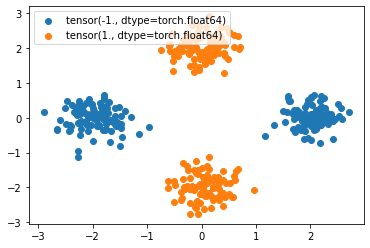

In [2]:
X, Y = load_data("toy_example") # four clusters

# X[:,0] += 1
print(torch.unique(Y))

# plot_data(X, Y)
K = torch.unique(Y, sorted=True)
for k in range(K.shape[0]):
    plt.scatter(X[Y==K[k], 0], X[Y==K[k], 1], label=K[k])
plt.legend()


N = X.shape[0]
indices = torch.randperm(N)
train_N = N*3//4 # 3 quarters of data is training. 
X_train = X[indices[0:train_N]]
Y_train = Y[indices[0:train_N]]
X_test = X[indices[train_N:]]
Y_test = Y[indices[train_N:]]

In [10]:
from ClusterSVM import *

CSVM = ClusterSVM(K=2, lamb=1e50)

CSVM.train(X_train, Y_train)
y_pred = CSVM.predict(X_test)

torch.true_divide(torch.sum(y_pred==Y_test),Y_test.shape[0])

tensor(1.)

# K-means

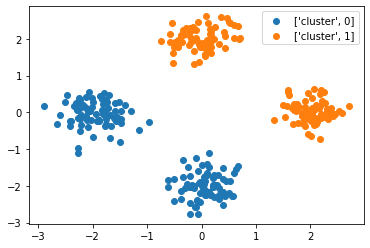

In [16]:
K = 2

# From SK-learn
# kmeans = KMeans(n_clusters=K).fit(X_train)
# print(kmeans.labels_[:10])
# print(kmeans.labels_[:10] == 0)

# From our implementation
cluster_id, centroid = Kmeans(X_train,K)

for l in range(K):
    # plt.scatter(X_train[kmeans.labels_==l,0], X_train[kmeans.labels_==l,1], label=['cluster',l])
    plt.scatter(X_train[cluster_id==l,0], X_train[cluster_id==l,1], label=['cluster',l])

plt.legend()

# Modified features and weighting for CSVM

In [17]:
N = X_train.shape[0]

# pre-processing
I_Nx1 = torch.ones(N,1)
X_train_with_ones = torch.cat((X_train,I_Nx1),dim=1)

D = X_train_with_ones.shape[1]

# global regularization
# larger the lamb, less global regularization effect
# smaller the lamb, larger global regulatization effect
lamb = 1e50
# lamb = 1
# lamb = 1e-50

X_train_hat = torch.zeros(N,D*(K+1), dtype=X.dtype, device=X.device)
X_train_hat[:,:D] = 1/np.sqrt(lamb)*X_train_with_ones

for l in range(K):
    # idl = kmeans.labels_ == l
    idl = cluster_id == l

    X_train_hat[idl, (D*(l+1)):(D*(l+2))] = X_train_with_ones[idl,:]

In [18]:
# Train linear lsvm from our implementation
LSVM = LinearSVM()
LSVM.train(X_train_hat, Y_train, reg=1, num_iters=2000, learning_rate=0.5)

W_hat = torch.tensor(LSVM.W, dtype=X.dtype)

# global regularizer
W = 1/np.sqrt(lamb)*W_hat[:D]

# DxK local regularizers matrix
# each column is a local regularizer
Wl = torch.zeros(D,K, dtype=X.dtype)
for l in range(K):
    Wl[:,l] = W_hat[(D*(1+l)):(D*(2+l))] + W

In [19]:
# Train linear svm from sklearn
Csvc = SVC(C=1,kernel='linear')
clf = Csvc.fit(X_train_hat,Y_train)

W_hat_sk = torch.tensor(clf.coef_, dtype=X.dtype)

# global regularizer
W_sk = 1/np.sqrt(lamb)*W_hat_sk[0,:D]

# DxK local regularizers matrix
# each column is a local regularizer
Wl_sk = torch.zeros(D,K, dtype=X.dtype)
for l in range(K):
    Wl_sk[:,l] = W_hat_sk[0,(D*(1+l)):(D*(l+2))] + W_sk

# Plotting

Cluster 

Prediction

Hyperplane
- Global 
- Local 

In [20]:
def plot_hyperplane(W,x_min,x_max, plane_name):
    w1 = W[0]
    w2 = W[1]
    b = W[2]

    line_x = torch.tensor([x_min,x_max])
    line_y_W = -w1/w2*line_x - b/w2

    plt.plot(line_x, line_y_W, label=plane_name)

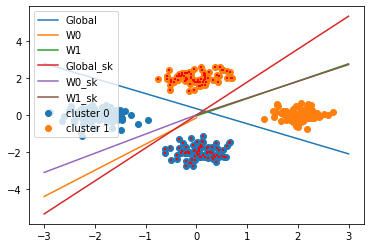

In [21]:
plot_hyperplane(W, -3, 3, 'Global')
plot_hyperplane(Wl[:,0], -3, 0, 'W0')
plot_hyperplane(Wl[:,1], 0, 3, 'W1')

plot_hyperplane(W_sk, -3, 3, 'Global_sk')
plot_hyperplane(Wl_sk[:,0], -3, 0, 'W0_sk')
plot_hyperplane(Wl_sk[:,1], 0, 3, 'W1_sk')


for l in range(K):
    # inl = kmeans.labels_ == l
    inl = cluster_id == l

    plt.scatter(X_train[inl,0], X_train[inl,1], label='cluster {}'.format(l))

    X_train_in_cluster_l = X_train_with_ones[inl,:]
    posIdx = torch.matmul(X_train_in_cluster_l, Wl[:,l]) > 0

    plt.scatter(X_train_in_cluster_l[posIdx,0], X_train_in_cluster_l[posIdx,1], s=5, c='r', marker='+')

plt.legend()

# red dot in the scatter represnet the data with y==1 

In [26]:
print(W)
print(W_sk)

tensor([ 7.2216e-52,  8.8675e-52, -3.0850e-52], dtype=torch.float64)
tensor([ 2.8883e-51, -1.6215e-51, -2.8287e-67], dtype=torch.float64)


## Validation with (X_test, y_test)

accuracy: 1.0


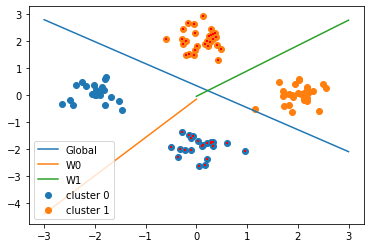

In [28]:
plot_hyperplane(W, -3, 3, 'Global')
plot_hyperplane(Wl[:,0], -3, 0, 'W0')
plot_hyperplane(Wl[:,1], 0, 3, 'W1')

# clustering by trained K-means
# cluster_labels = kmeans.predict(X_test)
cluster_labels = Kmeans_testdata(X_test, centroid)

# pre-processing
N_test = X_test.shape[0]

I_Nx1 = torch.ones(N_test,1)
X_test_with_ones = torch.cat((X_test,I_Nx1),dim=1)

# CSVM prediciton
acc = np.zeros((K,1))

for l in range(K):
    inl = cluster_labels == l

    plt.scatter(X_test[inl,0], X_test[inl,1], label='cluster {}'.format(l))

    X_test_in_cluster_l = X_test_with_ones[inl,:]
    posIdx = torch.matmul(X_test_in_cluster_l, Wl[:,l]) > 0

    acc[l] = torch.sum((Y_test[inl] == 1)== posIdx)
    # y_pred = LSVM.predict(X_test_in_cluster_l)
    # acc[l] = torch.sum((y_pred>0) == posIdx)

    plt.scatter(X_test_in_cluster_l[posIdx,0], X_test_in_cluster_l[posIdx,1], s=5, c='r', marker='+')

plt.legend()

print("accuracy:",np.sum(acc)/N_test)

# LSVM on the whole dataset

In [24]:
svc_simple = SVC(C=1,kernel='linear')
clf_simple = svc_simple.fit(X_test_with_ones,Y_test)

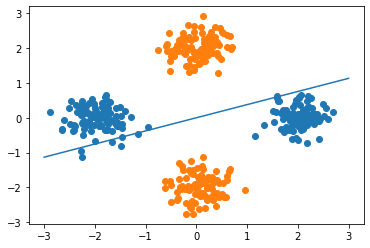

In [25]:
plot_data(X, Y)
plot_hyperplane(clf_simple.coef_[0], -3,3,'simple')